In [14]:
from pathlib import Path

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt

from dataset.cardiac_dataset1 import CardiacDataset
from dataset.model1 import UNet

In [15]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15),
              rotate=(-45, 45)),
    iaa.ElasticTransformation()
])

In [16]:
# Create the dataset objects
train_path = Path(
    "C:/Users/Owner/Downloads/Udemy/Pytorch/06-Atrium-Segmentation/06-Atrium-SegmentationPreprocessed/train/")
val_path = Path(
    "C:/Users/Owner/Downloads/Udemy/Pytorch/06-Atrium-Segmentation/06-Atrium-SegmentationPreprocessed/val")

train_dataset = CardiacDataset(train_path, seq)
val_dataset = CardiacDataset(val_path, None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 1932 train images and 339 val images


In [17]:
batch_size = 8
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


In [18]:
class DiceLoss(torch.nn.Module):
    """
    class to compute the Dice Loss
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
                
        # Flatten label and prediction tensors
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        counter = (pred * mask).sum()  # Numerator       
        denum = pred.sum() + mask.sum() + 1e-8  # Denominator. Add a small number to prevent NANS
        dice =  (2*counter)/denum
        return 1 - dice


In [19]:
class AtriumSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = UNet()
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = DiceLoss()
        
    def forward(self, data):
        return torch.sigmoid(self.model(data))
    
    def training_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)
        
        loss = self.loss_fn(pred, mask)
        
        self.log("Train Dice", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Train")
            
        return loss
    
    def validation_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)
        
        loss = self.loss_fn(pred, mask)
        
        self.log("Val Dice", loss)
        
        if batch_idx % 2 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Val")
            
        return loss
    
    def log_images(self, mri, pred, mask, name):
        
        pred = pred > 0.5
        
        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(mri[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0] == 0, mask[0][0])
        axis[0].imshow(mask_, alpha=0.6)
        
        axis[1].imshow(mri[0][0], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][0] == 0, pred[0][0])
        axis[1].imshow(mask_, alpha=0.6)
        
        self.logger.experiment.add_figure(name, fig, self.global_step)
        
    def configure_optimizers(self):
        return [self.optimizer]

In [20]:
# Instanciate the model and set the random seed
torch.manual_seed(0)
model = AtriumSegmentation()


In [21]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Dice',
    save_top_k=10,
    mode='min')


In [22]:
gpus = 1 #TODO
trainer = pl.Trainer(
    devices=gpus,  
    logger=TensorBoardLogger("./logs"),
    log_every_n_steps=1,
    default_root_dir="./weights",
    callbacks=checkpoint_callback,
    max_epochs=15 # change this value to make it run faster or more accurate
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | UNet     | 7.8 M 
1 | loss_fn | DiceLoss | 0     
-------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.127    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


# Evaluation

In [25]:
import nibabel as nib
from tqdm.notebook import tqdm
from celluloid import Camera


In [28]:
model = AtriumSegmentation.load_from_checkpoint(
    "C:/Users/Owner/Downloads/Udemy/Pytorch/06-Atrium-Segmentation/06-Atrium-Segmentation/weights/70.ckpt")

C:\Anaconda\envs\pytorch\Lib\site-packages\pytorch_lightning\utilities\migration\migration.py:201: PossibleUserWarning: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
  rank_zero_warn(
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.0.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file C:\Users\Owner\Downloads\Udemy\Pytorch\06-Atrium-Segmentation\06-Atrium-Segmentation\weights\70.ckpt`


In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval();
model.to(device);

In [30]:
preds = []
labels = []

for slice, label in tqdm(val_dataset):
    slice = torch.tensor(slice).to(device).unsqueeze(0)
    with torch.no_grad():
        pred = model(slice)
    preds.append(pred.cpu().numpy())
    labels.append(label)
    
preds = np.array(preds)
labels = np.array(labels)

  0%|          | 0/339 [00:00<?, ?it/s]

In [31]:
1-model.loss_fn(torch.from_numpy(preds), torch.from_numpy(labels))  # two possibilities

tensor(0.9539)

In [32]:
dice_score = 1-DiceLoss()(torch.from_numpy(preds), torch.from_numpy(labels).unsqueeze(0).float())
print(f"The Val Dice Score is: {dice_score}") # the closer to 1 the better it is

The Val Dice Score is: 0.9538518786430359


In [43]:
subject = Path("C:/Users/Owner/Downloads/Udemy/Pytorch/Task02_Heart/Task02_Heart/imagesTs/la_002.nii.gz")
subject_mri = nib.load(subject).get_fdata()

In [44]:
subject

WindowsPath('C:/Users/Owner/Downloads/Udemy/Pytorch/Task02_Heart/Task02_Heart/imagesTs/la_002.nii.gz')

In [45]:
# Helper functions for normalization and standardization
def normalize(full_volume):
    """
    Z-Normalization of the whole subject
    """
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized_data):
    """
    Standardize the normalized data into the 0-1 range
    """
    standardized_data = (normalized_data - normalized_data.min()) / (normalized_data.max() - normalized_data.min())
    return standardized_data


In [46]:
subject_mri = subject_mri[32:-32, 32:-32]
standardized_scan = standardize(normalize(subject_mri))

In [47]:
standardized_scan.shape

(256, 256, 140)

In [48]:
preds = []
for i in range(standardized_scan.shape[-1]):
    slice = standardized_scan[:,:,i]
    with torch.no_grad():
        pred = model(torch.tensor(slice).unsqueeze(0).unsqueeze(0).float().to(device))[0][0]
        pred = pred > 0.5
    preds.append(pred.cpu())

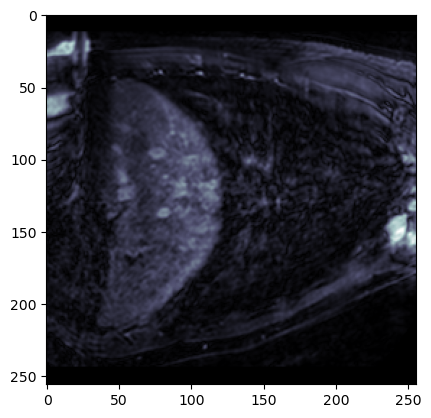

<Figure size 640x480 with 0 Axes>

In [53]:
for i in range(standardized_scan.shape[-1]):
    plt.imshow(standardized_scan[:,:,i], cmap="bone")
    mask = np.ma.masked_where(preds[i]==0, preds[i])
    plt.imshow(mask, alpha=0.5, cmap="autumn")
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation


fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid



In [52]:
from IPython.display import HTML
HTML(animation.to_html5_video())  # convert the animation to a video
